In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Suicide_Detection.csv', engine='python')

In [3]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâ€™m so lostHello, my name is Adam (16) and I...",suicide


In [4]:
df = pd.get_dummies(df, columns = ['class'], drop_first = True)

In [5]:
df = df.iloc[:,1:]

In [6]:
df = df.iloc[220000:]


In [7]:
df.shape

(12074, 2)

In [8]:
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Defining Features Matrix
X = df.drop(['class_suicide'], axis=1)
X.head()

,text
220000,My inability to sleep... ...It is frightening....
220001,I just woke up at 2 pm hows your day going?
220002,I want more snap streaks so I can see cute boi...
220003,I read an interesting article on notesI starte...
220004,The horrors of the climbing unit in Gym class ...


In [10]:
# Define Target
y = df['class_suicide']
y.head()

220000    0
220001    0
220002    0
220003    1
220004    0
Name: class_suicide, dtype: uint8

In [11]:
# Separate training and testing sets, stratifying by class
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [12]:
#Vamos a limpiar los datos de train y test
#Usamos Tokennizer que elimine los signos de puntuación y tags html
#Hacemos stemming para obtener las raices de las palabras en minusculas
#Eliminamos stopwords

In [13]:
def clean_reddit(text, tokenizer, stemmer, stopwords):
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(text)
    
    #Stemming : raiz y minusculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    #eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Equipo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#Eliminamos signos de puntuacion

tokenizer = RegexpTokenizer(r"\w+")

englishStemmer = SnowballStemmer("english")
stopwords_en = stopwords.words('english')
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

In [16]:
clean_train = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_train.text]

In [17]:
clean_test = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_test.text]

In [18]:
#CountVectorizer para transformar los datos de train y test

count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [19]:
X_train = pd.DataFrame(X_train_sparse.todense(), 
             columns = count_vectorizer.get_feature_names())

In [20]:
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [22]:
X_train_train, X_train_val, y_train_train, y_train_val = \
    train_test_split(X_train, y_train, train_size = 0.75, shuffle = True, random_state = 147)

for c in [0.005, 0.008, 0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c, solver="newton-cg", penalty="l2")    
    lr.fit(X_train_train, y_train_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_train_val, lr.predict(X_train_val))))

Accuracy for C=0.005: 0.8542402826855123
Accuracy for C=0.008: 0.8617491166077739
Accuracy for C=0.01: 0.8683745583038869
Accuracy for C=0.05: 0.8873674911660777
Accuracy for C=0.25: 0.8975265017667845
Accuracy for C=0.5: 0.898851590106007
Accuracy for C=1: 0.8957597173144877


In [23]:
final_model = LogisticRegression(C = 1, solver="newton-cg", penalty="l2")
final_model.fit(X_train, y_train)
print ("Final Accuracy: %s" 
        % accuracy_score(y_test, final_model.predict(X_test)))
print ("Final Confusion Matrix: \n %s" 
        % confusion_matrix(y_test, final_model.predict(X_test)))

Final Accuracy: 0.8903610467042067
Final Confusion Matrix: 
 [[1420   94]
 [ 237 1268]]


In [24]:
from yellowbrick.classifier import ROCAUC

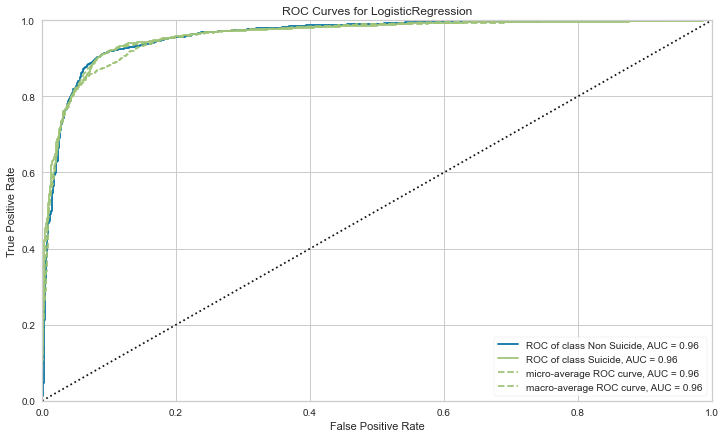

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [25]:
classes = ['Non Suicide','Suicide']
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(final_model, classes=classes, ax=ax)
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1514
           1       0.93      0.84      0.88      1505

    accuracy                           0.89      3019
   macro avg       0.89      0.89      0.89      3019
weighted avg       0.89      0.89      0.89      3019

